## 1. Introduction
  Diabetes is among the most prevalent chronic diseases in the United States, impacting millions of Americans each year and exerting a significant financial burden on the economy. Diabetes is a serious chronic disease in which individuals lose the ability to effectively regulate levels of glucose in the blood, and can lead to reduced quality of life and life expectancy.

  The goal of this project is to build a machine learning model that predicts whether a person has diabetes based on key risk factors.These risk factors include factors such as age, BMI (Body Mass Index), blood pressure, family history, and physical activity, among others.

## 2. Data Selection

  The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services

  I will be using the 2023 survey data from https://www.cdc.gov/brfss/annual_data/annual_2023.html, the data zip file is 2023 BRFSS Data (ASCII). 

Variable layout file is provided at https://www.cdc.gov/brfss/annual_data/2023/llcp_varlayout_23_onecolumn.html. Also each variable with the description and details of the values is provided https://www.cdc.gov/brfss/annual_data/2023/zip/codebook23_llcp-v2-508.zip.

  Data format is fixed width and also the column mapping is html file. This need work to prepare the data fileby parsing the column mapping and applying on data files.

* **Download the survey data from CDC**

In [1]:
# Download data file from cdc
!curl -L -o LLCP2023ASC.zip\
https://www.cdc.gov/brfss/annual_data/2023/files/LLCP2023ASC.zip
!unzip -o LLCP2023ASC.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.2M  100 57.2M    0     0  16.2M      0  0:00:03  0:00:03 --:--:-- 16.2M
Archive:  LLCP2023ASC.zip
  inflating: LLCP2023.ASC            


* **Access and parse the column specification to load the data file**

In [1]:
import requests
import pandas as pd

url = 'https://www.cdc.gov/brfss/annual_data/2023/llcp_varlayout_23_onecolumn.html'
html = requests.get(url).content
df_list = pd.read_html(html)
columns_df = df_list[-1]
columns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Starting Column  350 non-null    int64 
 1   Variable Name    350 non-null    object
 2   Field Length     350 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB


In [2]:
columns_df.head()

,Starting Column,Variable Name,Field Length
0,1,_STATE,2
1,17,FMONTH,2
2,19,IDATE,8
3,19,IMONTH,2
4,21,IDAY,2


In [3]:
# prepare column name and specification lists from the column dataframe
columns_df['colspec'] =list(zip(columns_df['Starting Column'], columns_df['Field Length']))
colspecs = columns_df['colspec'].tolist()
colnames = columns_df['Variable Name'].tolist()
colspecs_cleaned=[(x-1,x+y-1) for (x,y) in colspecs ]

In [4]:
print(f'column specifications size: {len(colspecs_cleaned)}')
print(f'Column names size : {len(colnames)}')

column specifications size: 350
Column names size : 350


* **Parse and load data to dataframe using prepared column specifications**

In [5]:
import pandas as pd

# Read the file
survey_df = pd.read_fwf('LLCP2023.ASC ', colspecs=colspecs_cleaned, header=None, names=colnames,encoding='windows-1252')
survey_df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1,1,3012023,3,1,2023,1100,2023000001,2023000001,1.0,...,0,1,0,1,2.0,2.0,2.0,1,1,9
1,1,1,1062023,1,6,2023,1100,2023000002,2023000002,1.0,...,0,1,0,1,1.0,1.0,2.0,1,1,9
2,1,1,3082023,3,8,2023,1100,2023000003,2023000003,1.0,...,0,1,0,1,1.0,1.0,2.0,1,1,9
3,1,1,3062023,3,6,2023,1100,2023000004,2023000004,1.0,...,0,1,0,1,1.0,1.0,1.0,1,1,9
4,1,1,1062023,1,6,2023,1100,2023000005,2023000005,1.0,...,7,1,47,1,2.0,1.0,2.0,1,1,2


* **Download the HTML containing column descriptions, parse it, and use the data for exploratory data analysis.**

In [6]:
# Download survey and variable descriptions html from cdc
!curl -L -o codebook23_llcp-v2-508.zip\
https://www.cdc.gov/brfss/annual_data/2023/zip/codebook23_llcp-v2-508.zip
!unzip -o codebook23_llcp-v2-508.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86998  100 86998    0     0   199k      0 --:--:-- --:--:-- --:--:--  199k
Archive:  codebook23_llcp-v2-508.zip
  inflating: USCODE23_LLCP_091024.HTML  


In [7]:
# extract the varible name and its survey question , this will be helpful on EDA
with open('USCODE23_LLCP_091024.HTML','r',encoding='windows-1252') as inf:
    data =inf.readlines()
from pyquery import PyQuery
from pprint import pprint
html = '\n'.join(data)
pq = PyQuery(html)
var_label_dict={}
for item in pq('body').items('div'):
    var_head =item('div table thead tr').eq(0)
    # Replace <br> tags with newlines
    td_element=var_head('td.linecontent').text()
    # Clean up the content (replace non-breaking spaces with regular spaces)
    cleaned_text = td_element.replace('&nbsp;', ' ').strip()
    # Split by new lines and print each cleaned line
    lines = cleaned_text.split('\n')
    dkey = ''
    for line in lines:
      uline = line.replace('\xa0',' ') #.encode('utf-8', 'ignore')
      #print(uline.strip().replace(' ','').upper())
      kvlist =uline.strip().split(':')
      if len(kvlist)==2:
          key,val = kvlist
          if key.strip().lower() == 'label':
              dkey = val.strip()
          if key.strip().lower() == 'sas variable name':
              var_label_dict[val.strip()] = dkey.replace('\n' ,' ')
              del(dkey)
# print sample
for key, value in var_label_dict.items():
    print(key, ":", value)
    break

_STATE : State FIPS Code


## 3.  Perform EDA 

Perform EDA on the Behavioral Risk Factor Surveillance System, i.e examine the dataset for missing values, outliers, and invalid data types. Visualize feature distributions and correlations to understand the relationships between variables and the target.

In [8]:
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(292), int64(58)
memory usage: 1.1 GB


In [9]:
# check if any duplicate columns with descriptions, as the survey happenned in multiple channels
key_len =len(var_label_dict.keys())
val_length =len(set(var_label_dict.values()))
dupcol = []
if key_len != val_length : 
    print(f"Duplicate columns by looking at descriptios are {key_len - val_length} ")
    res ={}
    for k,v in var_label_dict.items():
        if v in res:
            res[v].append(k)
        else:
            res[v] = [k]
    for k,v in res.items():
        if len(v) >2:
            print(f" {v} are duplicates of {k}")
            dupcol.append(v)
print( "Duplicate columns",  dupcol) 
for dupitem in dupcol:
    survey_df[dupitem].info()

Duplicate columns by looking at descriptios are 12 
 ['LANDSEX2', 'CELLSEX2', 'BIRTHSEX'] are duplicates of Are you male or female?
Duplicate columns [['LANDSEX2', 'CELLSEX2', 'BIRTHSEX']]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   LANDSEX2  70473 non-null   float64
 1   CELLSEX2  344976 non-null  float64
 2   BIRTHSEX  105230 non-null  float64
dtypes: float64(3)
memory usage: 9.9 MB


In [10]:
# make copy of survey_df to work with cleaning 
cleaned_survey_df = survey_df.copy()

In [11]:
# handle duplicates, check the column having major respnse and overlay missing from other responses
# fill CELLSEX2 if missing ones available in other 2 , only overlay value 1 or 2 as 1 => male 2=> female
cleaned_survey_df['CELLSEX2'] = cleaned_survey_df['CELLSEX2'].fillna(cleaned_survey_df['LANDSEX2'].where(cleaned_survey_df['LANDSEX2'].isin([1, 2])))
cleaned_survey_df['CELLSEX2'] = cleaned_survey_df['CELLSEX2'].fillna(cleaned_survey_df['BIRTHSEX'].where(cleaned_survey_df['BIRTHSEX'].isin([1, 2])))
cleaned_survey_df.drop(['BIRTHSEX','LANDSEX2'],axis=1,inplace=True)
cleaned_survey_df['CELLSEX2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 433323 entries, 0 to 433322
Series name: CELLSEX2
Non-Null Count   Dtype  
--------------   -----  
420203 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB


 **All the data fields are numeric, now check for missing and null values.**

In [12]:
# This is survey data and most of the features are either not answered or not relate to diabetic/health
# So I will be checking > 80% nulls
null_col_gt_80 =[]
for col in cleaned_survey_df.columns:
    if cleaned_survey_df[col].isna().sum() >0:
      if round((100 *cleaned_survey_df[col].isna().sum()/433323),2) >= 80:
        print(f"{col}({var_label_dict.get(col,'na')}): null percentage {round((100 *cleaned_survey_df[col].isna().sum()/433323),2)}")
        null_col_gt_80.append(col)
print(f"total number of columns with mulls % > 80 are {len(null_col_gt_80)}")

COLGHOUS(Do you live in college housing?): null percentage 100.0
RESPSLC1(Respondent selection): null percentage 87.91
LNDSXBRT(What was your sex at birth?): null percentage 99.96
CELSXBRT(What was your sex at birth?): null percentage 99.41
CCLGHOUS(Do you live in college housing?): null percentage 99.69
ASTHNOW(Still Have Asthma): null percentage 85.15
DIABAGE4(Age When First Told You Had Diabetes): null percentage 86.2
NUMPHON4(Residential Landline Phones): null percentage 98.31
PREGNANT(Pregnancy Status): null percentage 82.41
FALLINJ5(Injured in Fall or Had to see Doctor): null percentage 82.06
COVIDACT(Do long-term symptoms reduce ability to carry out activities?): null percentage 93.76
DIABTYPE(What type of diabetes do you have?): null percentage 94.4
INSULIN1(Now Taking Insulin): null percentage 94.4
CHKHEMO3(Times Checked for Glycosylated Hemoglobin): null percentage 94.4
EYEEXAM1(Last Eye Exam Where Pupils Were Dilated): null percentage 94.4
DIABEYE1(When was the last time a t

In [13]:
# dropping features having more than 80% nulls in the survey 
cleaned_survey_df = cleaned_survey_df.drop(columns=null_col_gt_80)

In [14]:
# now lets look at the target variable or label 
cleaned_survey_df['DIABETE4'].value_counts()

DIABETE4
3.0    358706
1.0     59786
4.0     10594
2.0      3253
7.0       683
9.0       296
Name: count, dtype: int64

In [15]:
# keep 1(diabetes), 3(no diabetes), 4 (pre-diabetes)
values_to_keep = [1.0,3.0, 4.0]
cleaned_survey_df = cleaned_survey_df[cleaned_survey_df['DIABETE4'].isin(values_to_keep)]

In [16]:
# This is survey data and most of the features are either not answered or not relate to diabetic/health
# So I will be checking > 80% nulls
null_col_gt_40 =[]
for col in cleaned_survey_df.columns:
    if cleaned_survey_df[col].isna().sum() >0:
      if round((100 *cleaned_survey_df[col].isna().sum()/433323),2) >= 40:
        print(f"{col}({var_label_dict.get(col,'na')}): null percentage {round((100 *cleaned_survey_df[col].isna().sum()/433323),2)}")
        null_col_gt_40.append(col)
print(f"total number of columns with mulls % > 40 are {len(null_col_gt_40)}")

CTELENM1(Correct telephone number?): null percentage 78.77
PVTRESD1(Private Residence?): null percentage 78.77
STATERE1(Resident of State): null percentage 78.77
CELPHON1(Cellular Telephone): null percentage 78.77
LADULT1(Are you 18 years of age or older?): null percentage 78.77
NUMADULT(Number of Adults in Household): null percentage 78.77
POORHLTH(Poor Physical or Mental Health): null percentage 41.5
EXEROFT2(How Many Times Walking, Running, Jogging, or Swimming): null percentage 46.71
EXERHMM2(Minutes or Hours Walking, Running, Jogging, or Swimming): null percentage 46.71
BPMEDS1(Currently Taking Prescription Blood Pressure Medication): null percentage 58.64
NUMHHOL4(Household Landline Telephones): null percentage 78.77
SMOKDAY2(Frequency of Days Now Smoking): null percentage 62.74
AVEDRNK3(Avg alcoholic drinks per day in past 30): null percentage 50.48
DRNK3GE5(Binge Drinking): null percentage 50.58
MAXDRNKS(Most drinks on single occasion past 30 days): null percentage 50.67
FLSHTM

In [17]:
# we still have 53 columns where null % is greater than 40 , review columns and see if they are relavant to keep 
cleaned_survey_df=cleaned_survey_df.drop(columns=null_col_gt_40)

In [18]:
cleaned_survey_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429086 entries, 0 to 433322
Columns: 155 entries, _STATE to _DRNKDRV
dtypes: float64(97), int64(58)
memory usage: 510.7 MB


In [19]:
for col in cleaned_survey_df.columns:
    if cleaned_survey_df[col].isna().sum() >10:
      if round((100 *cleaned_survey_df[col].isna().sum()/433323),2) >= 0:
        print(f"{col}({var_label_dict.get(col,'na')}): null percentage {round((100 *cleaned_survey_df[col].isna().sum()/433323),2)}")


SAFETIME(Safe time to talk): null percentage 20.26
CTELNUM1(Correct Phone Number?): null percentage 20.26
CELLFON5(Is this a cell phone?): null percentage 20.26
CADULT1(Are you 18 years of age or older?): null percentage 20.26
CELLSEX2(Are you male or female?): null percentage 3.01
PVTRESD3(Do you live in a private residence?): null percentage 20.26
CSTATE1(Do you currently live in  ____(state)____?): null percentage 20.26
LANDLINE(Do you also have a landline telephone?): null percentage 20.26
HHADULT(Number of Adults in Household): null percentage 20.26
EXRACT12(Type of Physical Activity): null percentage 24.68
EXEROFT1(How Many Times Walking, Running, Jogging, or Swimming): null percentage 25.17
EXERHMM1(Minutes or Hours Walking, Running, Jogging, or Swimming): null percentage 25.17
EXRACT22(Other Type of Physical Activity Giving Most Exercise During Past Month): null percentage 25.17
TOLDHI3(Ever Told Cholesterol Is High): null percentage 11.78
CHOLMED3(Currently taking medicine for

In [20]:
import warnings
warnings.filterwarnings("ignore")
# fill all integers with mode and floats with mean of total dataset
for column_name in cleaned_survey_df.columns:
    if cleaned_survey_df[column_name].dtype in ('float64',):
       cleaned_survey_df[column_name].fillna(cleaned_survey_df[column_name].mean(), inplace=True)
    if cleaned_survey_df[column_name].dtype in ('float64',):
       cleaned_survey_df[column_name].fillna(cleaned_survey_df[column_name].mean(), inplace=True)

In [21]:
# Identify columns with nulls
null_columns = cleaned_survey_df.columns[cleaned_survey_df.isnull().any()]
# Print the columns with nulls
print(null_columns)
cleaned_survey_df.isna().sum()

Index([], dtype='object')


_STATE      0
FMONTH      0
IDATE       0
IMONTH      0
IDAY        0
           ..
_RFDRHV8    0
_AIDTST4    0
_RFSEAT2    0
_RFSEAT3    0
_DRNKDRV    0
Length: 155, dtype: int64

In [22]:
# Now check summary of dataset
cleaned_survey_df.describe()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,SAFETIME,...,_CURECI2,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
count,429086.000000,429086.000000,4.290860e+05,429086.000000,429086.000000,429086.000000,429086.000000,4.290860e+05,4.290860e+05,429086.0,...,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000,429086.000000
mean,30.488166,6.612516,6.809092e+06,6.652289,15.478042,2023.058461,1117.769864,2.023005e+09,2.023005e+09,1.0,...,1.478168,1.977571,77.233019,1.736778,7794.653449,1.658176,2.027365,1.631703,1.697054,5.560659
std,16.673293,3.519124,3.429495e+06,3.428568,8.671601,0.234614,38.225930,4.455732e+03,4.455732e+03,0.0,...,1.799502,1.926480,225.131538,2.119595,26318.412366,2.109191,1.623200,2.071631,2.066439,3.515789
min,1.000000,1.000000,1.012024e+06,1.000000,1.000000,2023.000000,1100.000000,2.023000e+09,2.023000e+09,1.0,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,18.000000,3.000000,4.042023e+06,4.000000,8.000000,2023.000000,1100.000000,2.023002e+09,2.023002e+09,1.0,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000
50%,29.000000,7.000000,7.072023e+06,7.000000,15.000000,2023.000000,1100.000000,2.023004e+09,2.023004e+09,1.0,...,1.000000,2.000000,3.000000,1.000000,47.000000,1.000000,2.000000,1.000000,1.000000,9.000000
75%,45.000000,10.000000,1.006202e+07,10.000000,23.000000,2023.000000,1100.000000,2.023008e+09,2.023008e+09,1.0,...,1.000000,2.000000,29.000000,1.000000,400.000000,1.000000,2.000000,1.000000,1.000000,9.000000
max,78.000000,12.000000,1.231202e+07,12.000000,31.000000,2024.000000,1200.000000,2.023026e+09,2.023026e+09,1.0,...,9.000000,9.000000,900.000000,9.000000,99900.000000,9.000000,9.000000,9.000000,9.000000,9.000000


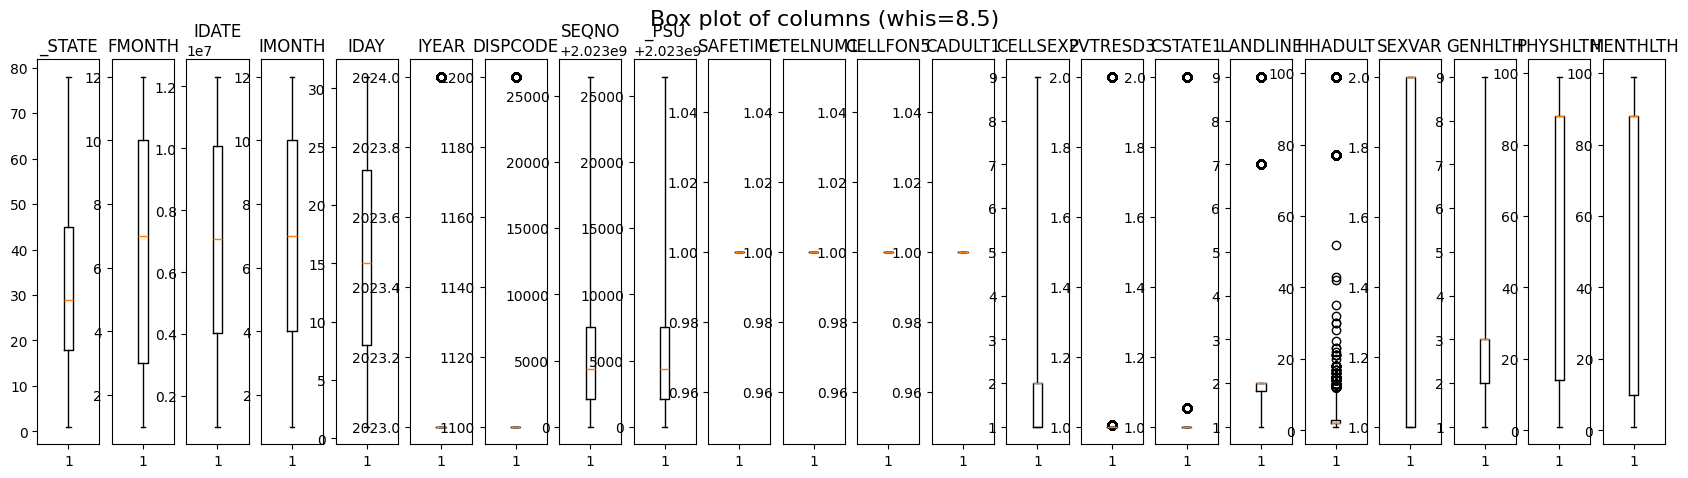

In [23]:
# Detect outliers in the data with box plots
import matplotlib.pyplot as plt
# Create the figure and axes
fig, axs = plt.subplots(1, 22, figsize=(21, 5))
for idx, cname in enumerate(cleaned_survey_df.columns):
    # Create the first box plot
    axs[idx].boxplot(cleaned_survey_df[cname],whis=8.5)
    axs[idx].set_title(cname)
    if idx > 20:
        break
fig.suptitle(f"Box plot of columns (whis=8.5)", fontsize=16)
plt.show()

In [24]:
# There are outliers in the dataset but there are pretty less, I will be treating the outliers with winsorization ,
# I will be capping at the 95th percentile to minimize their influence
from scipy.stats.mstats import winsorize
for column in cleaned_survey_df.columns:
  cleaned_survey_df[column] = winsorize(cleaned_survey_df[column],(0,0.05))


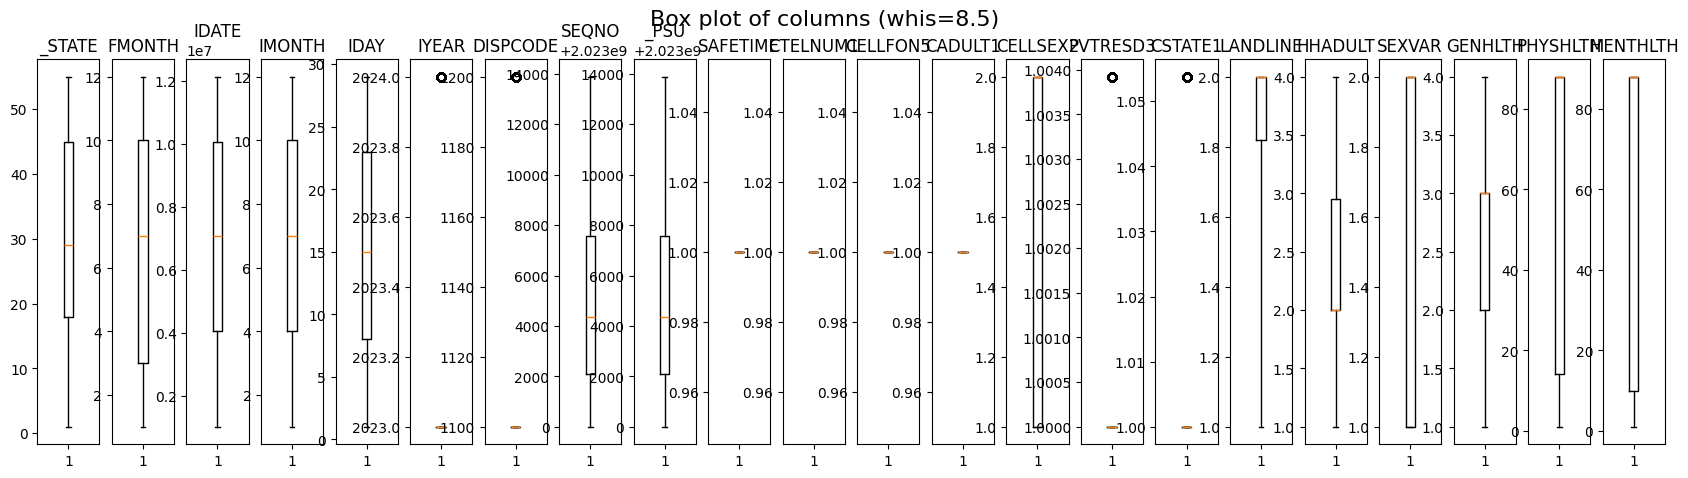

In [25]:
# replot 
import matplotlib.pyplot as plt
# Create the figure and axes
fig, axs = plt.subplots(1, 22, figsize=(21, 5))
for idx, cname in enumerate(cleaned_survey_df.columns):
    # Create the first box plot
    axs[idx].boxplot(cleaned_survey_df[cname],whis=8.5)
    axs[idx].set_title(cname)
    if idx > 20:
        break
fig.suptitle(f"Box plot of columns (whis=8.5)", fontsize=16)
plt.show()

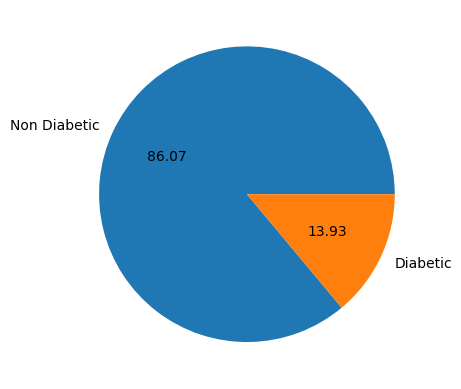

In [26]:
# percent of spam and non spam emails in the list
import matplotlib.pyplot as plt
plt.pie(cleaned_survey_df['DIABETE4'].value_counts(), labels=['Non Diabetic','Diabetic'],autopct="%0.2f")
plt.show()

Above pie chart shows the percentage of the diabetic and non diabetic persons in the dataset

In [27]:
# use Chi-Square test to check top features that are highly correlated
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Assume the target is categorical
X_test = cleaned_survey_df.drop(columns=['DIABETE4'])  # features
y_test = cleaned_survey_df['DIABETE4']  # target

# Perform the Chi-Square test to find the most important features
chi2_selector = SelectKBest(chi2, k='all')  # Use k='all' to test all features
X_new = chi2_selector.fit_transform(X_test, y_test)

# Get p-values and scores
p_values = chi2_selector.pvalues_
scores = chi2_selector.scores_

# Create a DataFrame of scores and p-values
chi2_results = pd.DataFrame({
    'Feature': X_test.columns,
    'Chi2 Score': scores,
    'P-Value': p_values
})

# Sort by Chi-Square score
chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False)

# Show the top features
chi2_results['Decription'] = chi2_results['Feature'].map(var_label_dict)
print(chi2_results.head(15))
top_features=chi2_results.head(5)['Feature'].tolist()

      Feature    Chi2 Score  P-Value  \
148  _DRNKWK2  9.454641e+06      0.0   
93   MAXVO21_  4.753045e+06      0.0   
100  STRFREQ_  4.393888e+06      0.0   
135     WTKG3  4.126790e+06      0.0   
66    ALCDAY4  1.950910e+06      0.0   
136     _BMI5  1.555723e+06      0.0   
94     FC601_  8.146652e+05      0.0   
31   STRENGTH  7.940249e+05      0.0   
77     _STSTR  7.796719e+05      0.0   
85    _LLCPWT  4.057335e+05      0.0   
105  PA3VIGM_  3.414565e+05      0.0   
104  PAVIG13_  2.339997e+05      0.0   
146  DROCDY4_  1.597287e+05      0.0   
131    _AGE80  1.113949e+05      0.0   
103   PA3MIN_  1.054058e+05      0.0   

                                            Decription  
148  Computed number of drinks of alcohol beverages...  
93   Estimated Age-Gender Specific Maximum Oxygen C...  
100               Strength Activity Frequency per Week  
135                       Computed Weight in Kilograms  
66              Days in past 30 had alcoholic beverage  
136              

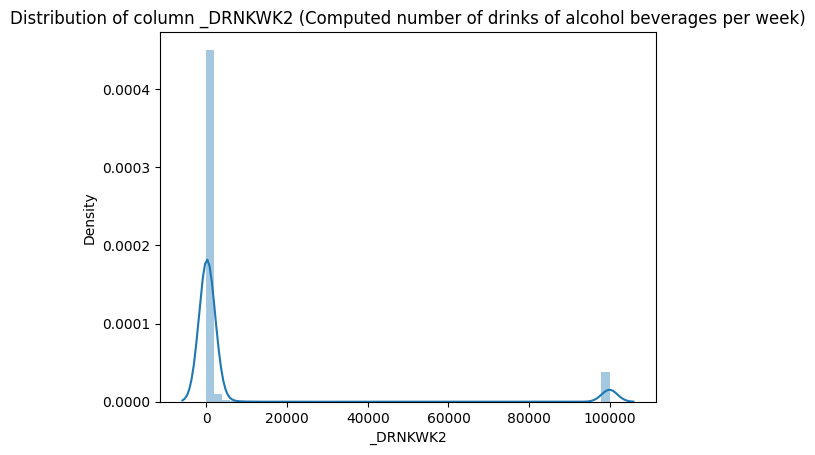

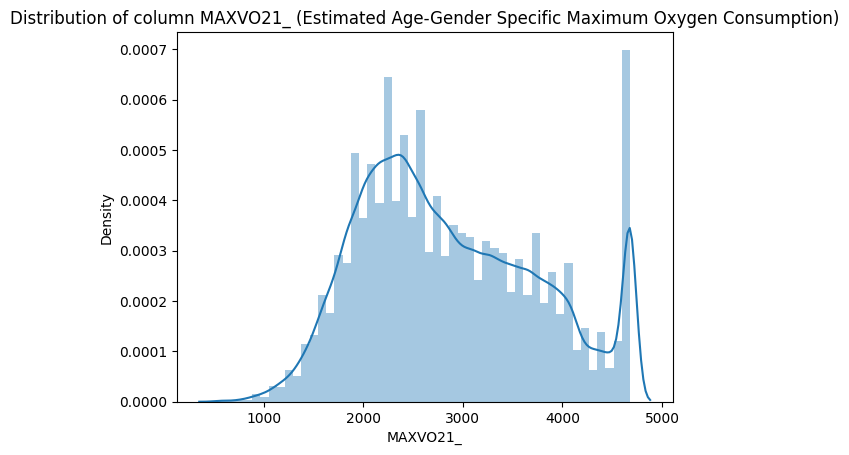

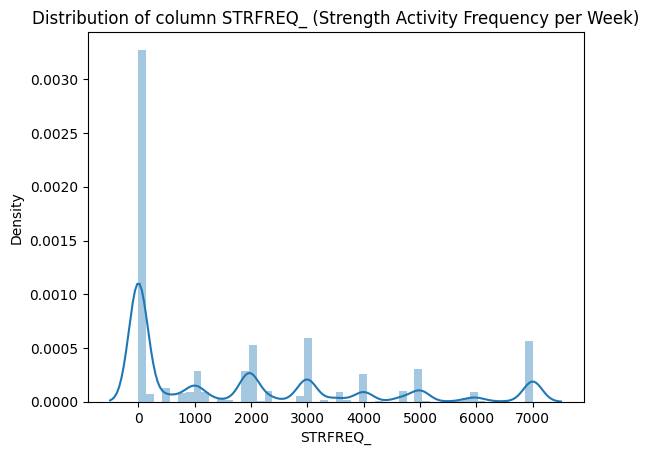

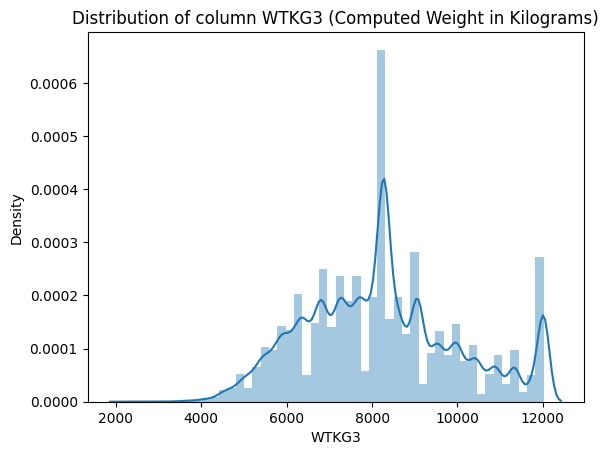

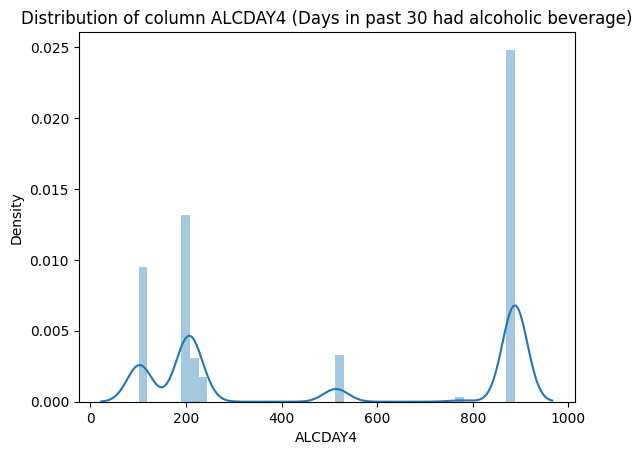

In [28]:
# plot distribution for input columns
import seaborn as sns
def plot_cols(cols):
  for col in cols:
    sns.distplot(cleaned_survey_df[col]).set_title(f'Distribution of column {col} ({var_label_dict.get(col)})')
    plt.show()
# plot the target column and see the distribution 
plot_cols(top_features)

* Data distribution does not look normal, and it would need feature standardization to be effectively run the models

<Axes: >

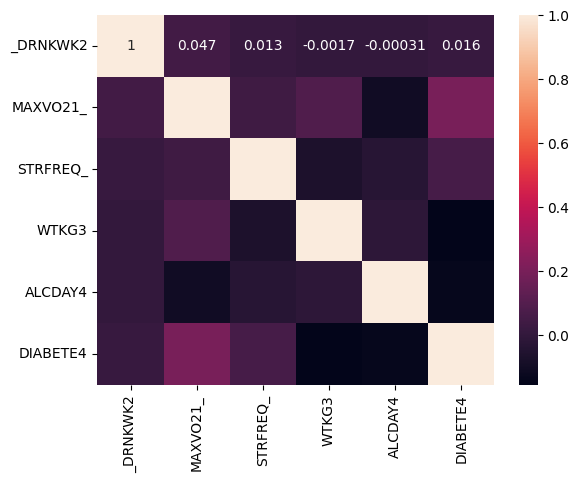

In [29]:
# heat map for top 10 spam words
import seaborn as sns
sns.heatmap(cleaned_survey_df[top_features + ['DIABETE4']].corr(),annot=True)

In [30]:
cleaned_survey_df[top_features + ['DIABETE4']].corr()

,_DRNKWK2,MAXVO21_,STRFREQ_,WTKG3,ALCDAY4,DIABETE4
_DRNKWK2,1.000000,0.046633,0.013423,-0.001658,-0.000309,0.015747
MAXVO21_,0.046633,1.000000,0.034694,0.087906,-0.101487,0.198788
STRFREQ_,0.013423,0.034694,1.000000,-0.065844,-0.034613,0.060457
WTKG3,-0.001658,0.087906,-0.065844,1.000000,-0.015625,-0.155442
ALCDAY4,-0.000309,-0.101487,-0.034613,-0.015625,1.000000,-0.138675
DIABETE4,0.015747,0.198788,0.060457,-0.155442,-0.138675,1.000000


## Feature Engineering
From heat map and the correlation matrics , the top features are contributing good amount variance. Also most of the features are not related to health.
* I will be listing all features and first removing the non health related features in the dataset.
* Standardization also applied as data not in normal distributions.
* Next if we still left with many features , if needed I will apply dimentionality reduction techniques to the data.

In [31]:
for col in cleaned_survey_df.columns:
    print(f"{col} : {var_label_dict.get(col)}")

_STATE : State FIPS Code
FMONTH : File Month
IDATE : Interview Date
IMONTH : Interview Month
IDAY : Interview Day
IYEAR : Interview Year
DISPCODE : Final Disposition
SEQNO : Annual Sequence Number
_PSU : Primary Sampling Unit
SAFETIME : Safe time to talk
CTELNUM1 : Correct Phone Number?
CELLFON5 : Is this a cell phone?
CADULT1 : Are you 18 years of age or older?
CELLSEX2 : Are you male or female?
PVTRESD3 : Do you live in a private residence?
CSTATE1 : Do you currently live in  ____(state)____?
LANDLINE : Do you also have a landline telephone?
HHADULT : Number of Adults in Household
SEXVAR : Sex of Respondent
GENHLTH : General Health
PHYSHLTH : Number of Days Physical Health Not Good
MENTHLTH : Number of Days Mental Health Not Good
PRIMINS1 : What is Current Primary Source of Health Insurance?
PERSDOC3 : Have Personal Health Care Provider?
MEDCOST1 : Could Not Afford To See Doctor
CHECKUP1 : Length of time since last routine checkup
EXERANY2 : Exercise in Past 30 Days
EXRACT12 : Type o

### Below variables are not health related , so I will be dropping them from the feature set 
QSTVER : Questionnaire Version Identifier \
QSTLANG : Language identifier \ 
PVTRESD3 : Do you live in a private residence?\
CSTATE1 : Do you currently live in  ____(state)____?\
LANDLINE : Do you also have a landline telephone?\
_STATE : State FIPS Code\
FMONTH : File Month\
IDATE : Interview Date\
IMONTH : Interview Month\
IDAY : Interview Day\
IYEAR : Interview Year\
DISPCODE : Final Disposition\
SEQNO : Annual Sequence Number\
_PSU : Primary Sampling Unit\
SAFETIME : Safe time to talk\
CTELNUM1 : Correct Phone Number?\
CELLFON5 : Is this a cell phone?

In [32]:
# droping not related columns 
drop_list=['QSTVER','QSTLANG','PVTRESD3','CSTATE1','LANDLINE','_STATE','FMONTH','IDATE','IMONTH','IDAY',
          'IYEAR','DISPCODE','SEQNO','_PSU','SAFETIME','CTELNUM1','CELLFON5','CPDEMO1C']
cleaned_survey_df.drop(drop_list,axis=1,inplace=True)
cleaned_survey_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429086 entries, 0 to 433322
Columns: 137 entries, CADULT1 to _DRNKDRV
dtypes: float64(90), int64(47)
memory usage: 451.8 MB


In [33]:
cleaned_survey_df['DIABETE4'].value_counts()
# encode the target column with 0 - no diabetes and 1 as diabetes
cleaned_survey_df['Target'] = cleaned_survey_df['DIABETE4'].apply(lambda x: 0 if x == 3 else 1)
cleaned_survey_df.drop(['DIABETE4'],axis=1,inplace=True)
cleaned_survey_df['Target'].value_counts()

Target
0    369300
1     59786
Name: count, dtype: int64

## Standardization and prepare text and train datasets
The dataset contains 137 features, which makes it a prime candidate for dimensionality reduction. By reducing the number of features, we can streamline the data, allowing the model to run more efficiently, even with limited computational resources.

* First standardize the dataset
* Prepare test and train datasets for model training


In [79]:
from sklearn.preprocessing import StandardScaler
# reset the index on dataframe, to properly plot the clustering
cleaned_survey_df = cleaned_survey_df.reset_index(drop=True)
# Define the features and the outcome
X = cleaned_survey_df.drop(['Target'],axis=1,inplace=False)
y = cleaned_survey_df['Target']

# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
METRICS_DICT={}

In [35]:
# common method to plot the confusion matrix 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [36]:
# common method to print the model metrics 
def print_add_metrics(model_name,y_test,predictions,train_score):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    fbeta_precision = fbeta_score(y_test, predictions, beta=0.5)
    fbeta_recall = fbeta_score(y_test, predictions, beta=2)
    print('Score on training data: ', train_score)
    print('On test data:')
    print('    Accuracy score: {:.2f}'.format(accuracy))
    print('    Precision score: {:.2f}'.format(precision))
    print('    Recall score: {:.2f}'.format(recall))
    print('    F1 score: {:.2f}'.format(f1))
    print('    Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
    print('    FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
    METRICS_DICT[model_name] = [train_score,accuracy,precision,recall,f1,fbeta_precision,fbeta_recall]

In [39]:
# split train and test datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_std,y, random_state=2)

## Perform Classification using Supervised Learning  

* Run linear classifier and see performance
* Run the random forest classifier and mesure performance, tune hyper parameters
* Build and Run Gradient boosting model, tune hyper parameters
* Compare metrics from above supervised learning models and select best performning model

### 1. Linear Classifier

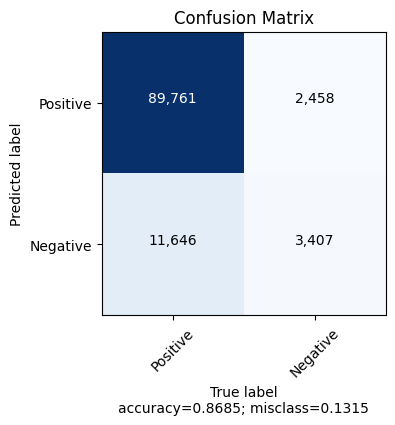

Score on training data:  0.8700957696060457
On test data:
    Accuracy score: 0.87
    Precision score: 0.58
    Recall score: 0.23
    F1 score: 0.33
    Fbeta score favoring precision: 0.44
    FBeta score favoring recall: 0.26


In [40]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=0.6, random_state=2)
lr.fit(X_train, y_train)
train_score = lr.score(X_train, y_train)
confusion= confusion_matrix(y_test, lr.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = 'Confusion Matrix',normalize=False)
print_add_metrics("linear_classifier",y_test,lr.predict(X_test),train_score)

Accuracy scores for the 5 folds:  [0.87004956 0.86950577 0.87001849 0.86983205 0.86962804]
Mean cross validation score: 0.870


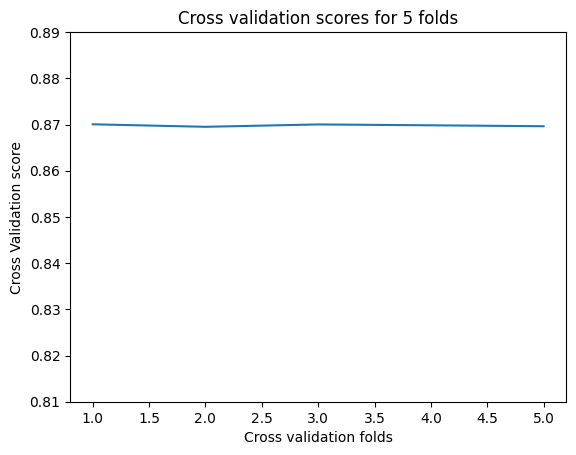

In [51]:
# run cross validation to identify if your model is overfitting
import numpy as np
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
# Create the line plot
plt.plot([ x+1 for x in range(len(cv_scores))], cv_scores)

# Add labels and title
plt.xlabel("Cross validation folds")
plt.ylabel("Cross Validation score")
plt.title(f"Cross validation scores for {len(cv_scores)} folds")
# Set the y-axis scale
plt.ylim(0.81, 0.89)
# Display the plot
plt.show()

    The cross-validation scores and their mean are approximately equal, indicating that the model's performance is consistent across all folds. This suggests that the model is generalizing well, with similar performance on both the training (seen) and validation (unseen) data. Therefore, we can conclude that the model is not overfitting and is likely to perform reliably on new, unseen data in real-world scenarios.

### 2. Random Forest (ensemble model)

In [304]:
# Random Forest - Prepare the grid and  tune hyperparameters for the model , especially estimators and tree depth
# In this step we will prepare random forest hyper parameter grid and try to find the best values for the parameters
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 4)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
from sklearn import ensemble
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ensemble.RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_std, y)

In [312]:
# Print Random forest best parameters list
rf_random.best_params_

{'n_estimators': 150, 'max_depth': None}

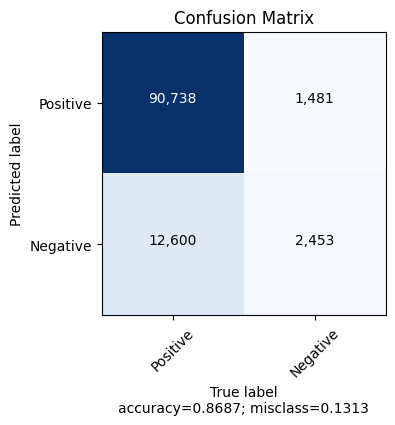

Score on training data:  1.0
On test data:
    Accuracy score: 0.87
    Precision score: 0.62
    Recall score: 0.16
    F1 score: 0.26
    Fbeta score favoring precision: 0.40
    FBeta score favoring recall: 0.19


In [53]:
# Run Random forest with best parameters 
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(n_estimators=150, n_jobs=-1)
rfc.fit(X_train, y_train)
train_score = rfc.score(X_train, y_train)
confusion= confusion_matrix(y_test, rfc.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = 'Confusion Matrix',normalize=False)
print_add_metrics("Random Forest",y_test,rfc.predict(X_test),train_score)

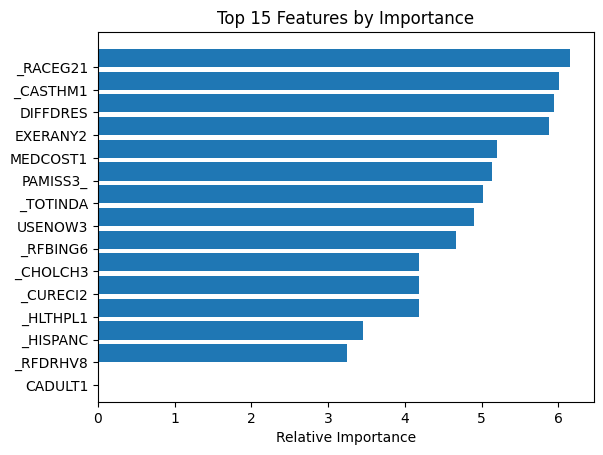

Variable descriptions: 
 CADULT1 : Are you 18 years of age or older?
 _RFDRHV8 : Heavy Alcohol Consumption  Calculated Variable
 _HISPANC : Hispanic, Latino/a, or Spanish origin calculated variable
 _HLTHPL1 : Have any health insurance
 _CURECI2 : Current E-cigarette User Calculated Variable
 _CHOLCH3 : Cholesterol Checked Calculated Variable
 _RFBING6 : Binge Drinking Calculated Variable
 USENOW3 : Use of Smokeless Tobacco Products
 _TOTINDA : Leisure Time Physical Activity Calculated Variable
 PAMISS3_ : Missing Physical Activity Data
 MEDCOST1 : Could Not Afford To See Doctor
 EXERANY2 : Exercise in Past 30 Days
 DIFFDRES : Difficulty Dressing or Bathing
 _CASTHM1 : Current Asthma Calculated Variable
 _RACEG21 : Create Computed Non-Hispanic Whites/All Others Race Categories Race/Ethnic Group Codes Used In Post-Stratification Variable


In [55]:
feature_importance = rfc.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + 150
pos = np.arange(15) + 150
#fig, ax = plt.subplots(figsize=(8, 6))
#plt.subplot(figsize=(8, 6))
plt.barh(pos, feature_importance[sorted_idx][:15], align='edge')
plt.yticks(pos, X.columns[sorted_idx][:15])
plt.xlabel('Relative Importance')
plt.title('Top 15 Features by Importance')
plt.show()
print("Variable descriptions: ")
for var in X.columns[sorted_idx][:15]:
    print(f" {var} : {var_label_dict.get(var)}")

* It is very interesting to see the highly impacting features , especially have any health insurance. This can be an indicator of household income status. This inturn can impact on the physical or mental health.

[0.86707917 0.86929163 0.86894205 0.86930328 0.86894205]

Cross-validation time elapsed: 72.44 seconds.


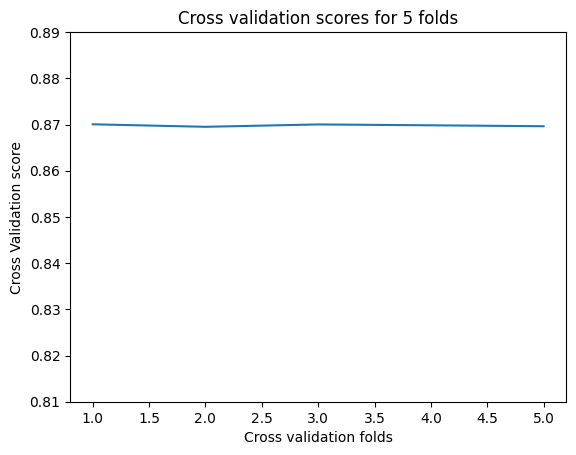

In [56]:
# Run Cross validation for random forest to see the model fit status
from sklearn import ensemble
import time
start = time.time()
cvrfc = ensemble.RandomForestClassifier(n_estimators=150, n_jobs=-1)
print(f'{cross_val_score(cvrfc, X_std, y, cv=5)}\n')
print(f'Cross-validation time elapsed: {round(time.time() - start, 2)} seconds.')
# Create the line plot
plt.plot([ x+1 for x in range(len(cv_scores))], cv_scores)

# Add labels and title
plt.xlabel("Cross validation folds")
plt.ylabel("Cross Validation score")
plt.title(f"Cross validation scores for {len(cv_scores)} folds")
# Set the y-axis scale
plt.ylim(0.81, 0.89)
# Display the plot
plt.show()

    The cross-validation scores and their mean are approximately equal, indicating that the model's performance is consistent across all folds. This suggests that the model is generalizing well, with similar performance on both the training (seen) and validation (unseen) data. Therefore, we can conclude that the model is not overfitting and is likely to perform reliably on new, unseen data in real-world scenarios.

### 3.Gradient boosting model 

In [337]:
# tune the hyper parameters for the Gradient boosting and select the best parameters
# Import necessary libraries
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'loss': ['exponential','log_loss']
}

# Initialize the Gradient Boosting model
gb_model = ensemble.GradientBoostingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=2, verbose=2, n_jobs=-1,score='balanced_accuracy')

# Fit the model to the training data using GridSearchCV
grid_search.fit(X_std, y)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
# Print the results
print("Best Parameters:", best_params)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=50; total time= 2.7min
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=50; total time= 2.8min
[CV] END learning_rate=0.01, loss=exponential, max_depth=5, n_estimators=50; total time= 4.5min
[CV] END learning_rate=0.01, loss=exponential, max_depth=5, n_estimators=50; total time= 4.6min
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=100; total time= 5.7min
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=100; total time= 5.7min
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=150; total time= 8.4min
[CV] END learning_rate=0.01, loss=exponential, max_depth=3, n_estimators=150; total time= 8.4min
[CV] END learning_rate=0.01, loss=exponential, max_depth=7, n_estimators=50; total time= 6.1min
[CV] END learning_rate=0.01, loss=exponential, max_depth=7, n_estimato

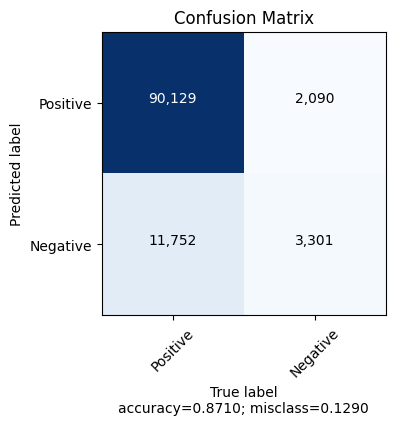

Score on training data:  0.8761023448327294
On test data:
    Accuracy score: 0.87
    Precision score: 0.61
    Recall score: 0.22
    F1 score: 0.32
    Fbeta score favoring precision: 0.45
    FBeta score favoring recall: 0.25


In [61]:
# You'll make 500 iterations, use 2-deep trees, and set your loss function.
params = {'n_estimators': 50,
          'max_depth': 7,
          'loss': 'exponential',
         'learning_rate':0.1}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)

train_score = gbc.score(X_train, y_train)
confusion= confusion_matrix(y_test, gbc.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = 'Confusion Matrix',normalize=False)
print_add_metrics("Gradient Boosting",y_test,gbc.predict(X_test),train_score)

In [ ]:
Score on training data:  0.8723548385092009
On test data:
    Accuracy score: 0.87
    Precision score: 0.59
    Recall score: 0.24
    F1 score: 0.35
    Fbeta score favoring precision: 0.46
    FBeta score favoring recall: 0.28

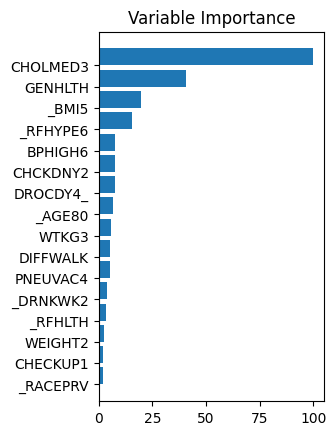

 _RACEPRV : Computed race groups used for internet prevalence tables
 CHECKUP1 : Length of time since last routine checkup
 WEIGHT2 : Reported Weight in Pounds
 _RFHLTH : Adults with good or better health
 _DRNKWK2 : Computed number of drinks of alcohol beverages per week
 PNEUVAC4 : Pneumonia shot ever
 DIFFWALK : Difficulty Walking or Climbing Stairs
 WTKG3 : Computed Weight in Kilograms
 _AGE80 : Imputed Age value collapsed above 80
 DROCDY4_ : Computed drink-occasions-per-day
 CHCKDNY2 : Ever told you have kidney disease?
 BPHIGH6 : Ever Told Blood Pressure High
 _RFHYPE6 : High Blood Pressure Calculated Variable
 _BMI5 : Computed body mass index
 GENHLTH : General Health
 CHOLMED3 : Currently taking medicine for high cholesterol


In [62]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(16) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][120:], align='edge')
plt.yticks(pos, X.columns[sorted_idx][120:])
plt.title('Top 15 Features by Importance')
plt.title('Variable Importance')
plt.show()
for var in X.columns[sorted_idx][120:]:
    print(f" {var} : {var_label_dict.get(var)}")

### Selecting Supervised learning model based on performance

In [ ]:
# todo compare models and select the best 

## Perform UnSupervised Clustering techniques  

* Apply dimentionality reduction technique , try PCA and UMAP and select the best one which preserve clusters information.
* I will apply simple k means to cluster the data and see performanace
* I will apply Gaussian mixture soft clustering algorithm and measure the performance
* select best one based on metrics

#### Apply dimentionality reduction

 PCA explained variance for components: [0.09120403 0.06639345 0.06165697 0.04937341 0.03835403 0.03742354
 0.02879846 0.02472841 0.02394997 0.02260702 0.01930421 0.01721214
 0.01619895 0.01612943 0.01558813]


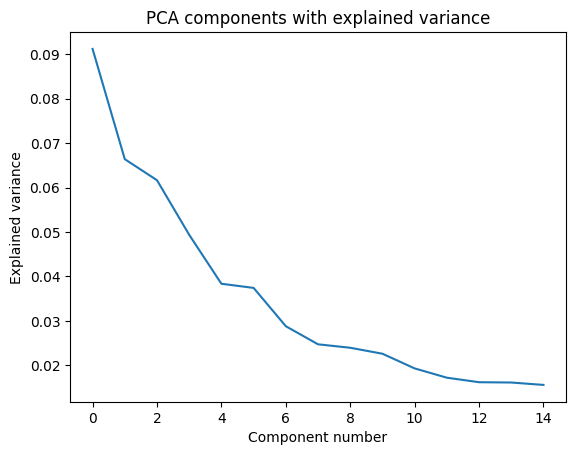

In [80]:
from sklearn.decomposition import PCA
# Try with 5 components and see the explained variance for components
pca = PCA(n_components=15)

# Get the components by 
# calling `fit_transform()` method with the data
pca_components = pca.fit_transform(X_std)
import matplotlib.pyplot as plt

print(f" PCA explained variance for components: {pca.explained_variance_ratio_}")
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('Explained variance')
plt.title('PCA components with explained variance')
plt.show()

In [81]:
# from data above 6 components looks optimal so will go a head with 2 components
pca = PCA(n_components=12)

# Get the components by 
# calling `fit_transform()` method with the data
pca_components = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
pca_components

[0.09120403 0.06639345 0.06165697 0.04937341 0.03835403 0.03742354
 0.02879846 0.02472841 0.02394997 0.02260702 0.01930421 0.01721214]


array([[ 3.74190053,  0.78704179,  0.31576931, ...,  2.46401316,
         3.33439102,  1.13875856],
       [ 4.75005247,  0.84164603,  1.23176647, ...,  1.02274944,
         1.56474603,  0.75866907],
       [ 2.31443296,  3.83293464,  8.69199584, ..., -2.87651393,
         0.50768409, -0.84282529],
       ...,
       [-3.60571395, -0.67431662,  2.43054109, ...,  0.97919255,
        -3.68003506,  1.22108902],
       [ 0.38828596,  2.42317782,  5.84520711, ...,  0.17642881,
        -0.65690973, -0.91741388],
       [-5.22575876,  1.48581515,  5.23777804, ..., -4.84173185,
         2.04062921, -1.65300045]])

In [82]:
# now try umap dimensionality reduction on data
import umap
import time
time_start = time.time()

umap_results = umap.UMAP(n_components=6,
                         n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 67.71366310119629 seconds


In [83]:
def plot_label(components,dtype):
    ''' plot components 
      plot components with color and target labels and colors '''
    plt.figure(figsize=(1, 1))
    plt.text(0.01, 0.01, f" Dimensionality reduction with {dtype}", fontsize=10)
    plt.axis('off')  # Hide the axes
    plt.show()
    plt.figure(figsize=(.75, 0.45))
    if dtype == 'UMAP':
         plt.figure(figsize=(2, 1))
    colours = ["r", "b", "g"]
    for i in range(components.shape[0]):
        plt.text(components[i, 0], components[i, 1], str(y.iloc[i]),
                 color=colours[int(y.iloc[i])],
                 fontdict={'weight': 'bold', 'size': 30}
                 )
    plt.show()


def plot(components,dtype):
    ''' plot components 
      scatter plot components '''
    plt.figure(figsize=(10, 5))
    plt.scatter(components[:, 0], components[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(f" Dimensionality reduction with {dtype}",y=1.05)
    plt.show()

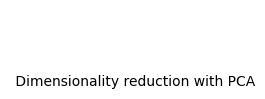

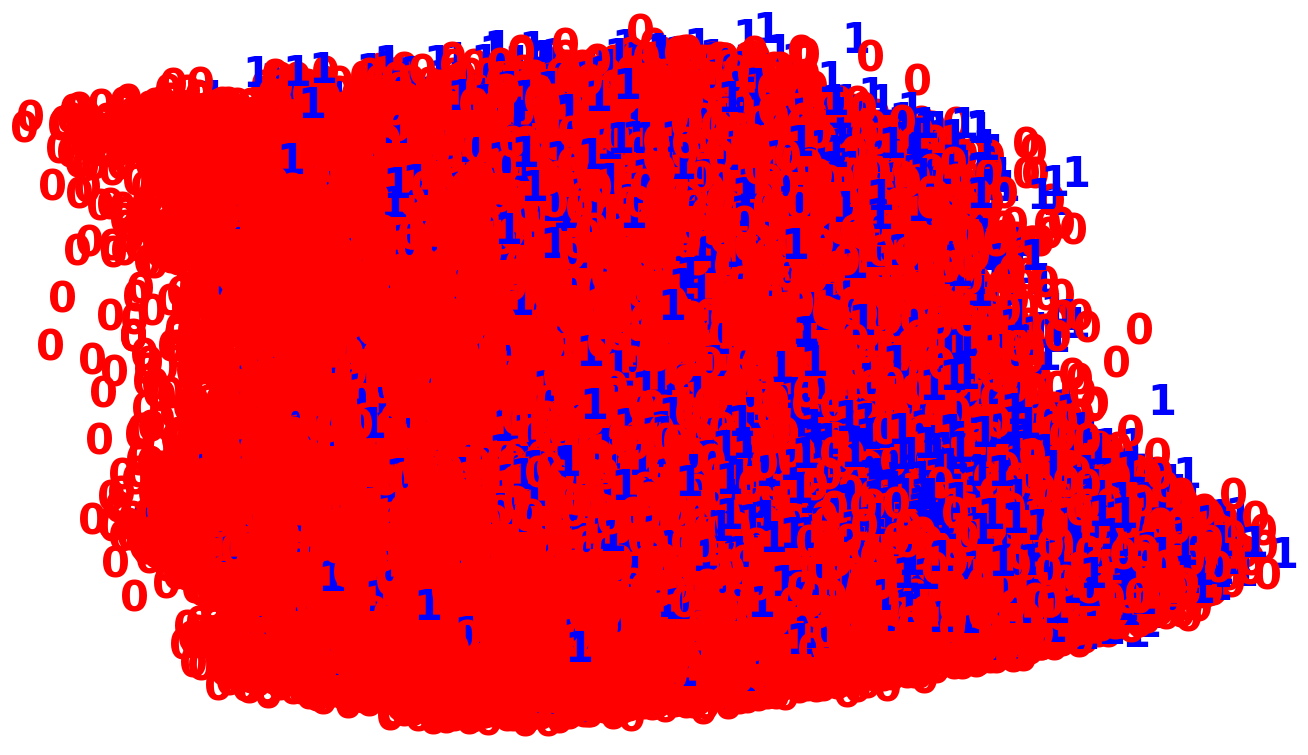

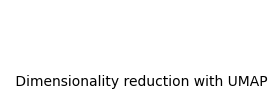

<Figure size 75x45 with 0 Axes>

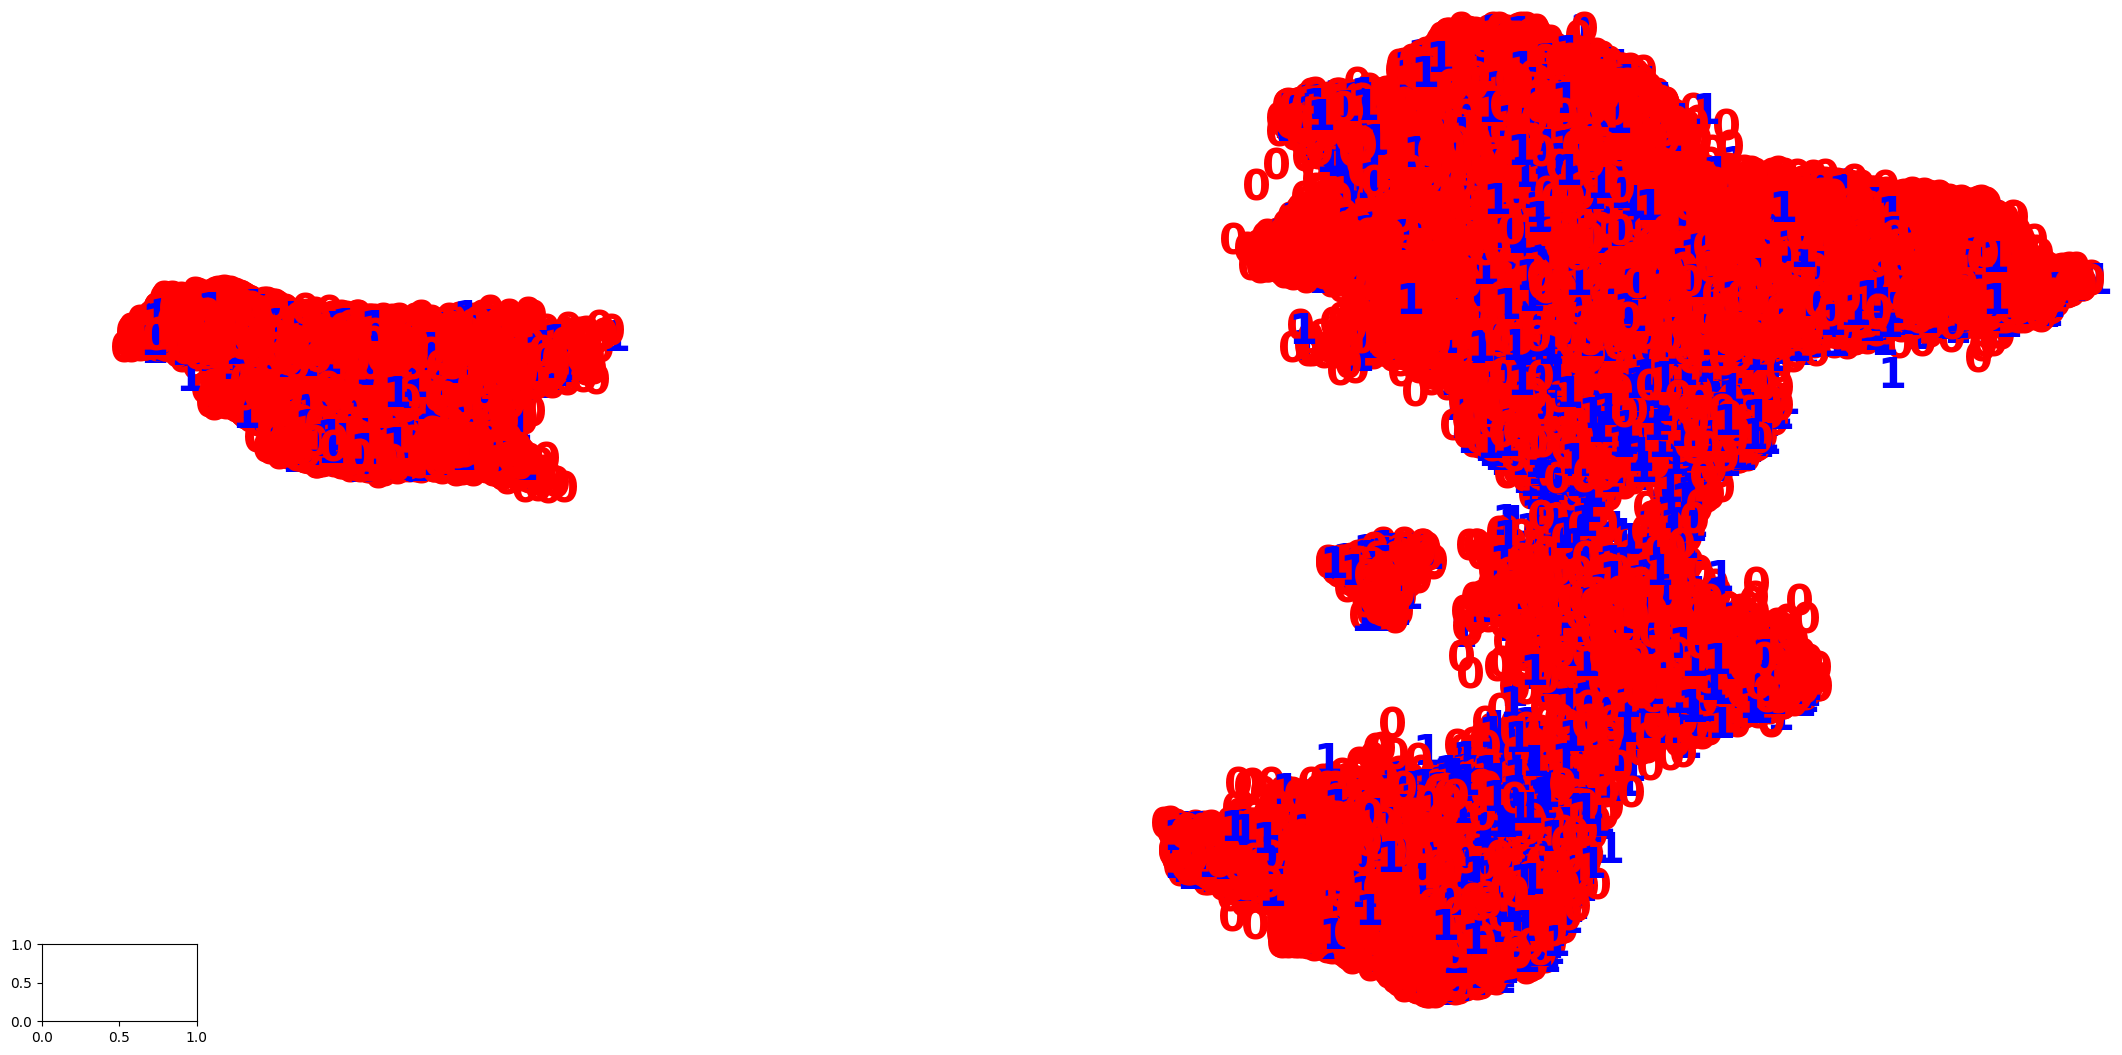

In [84]:
# scatter plot the PCA 
# time to compare PCA and T-SNE
plot_label(pca_components,"PCA")
plot_label(umap_results,"UMAP")

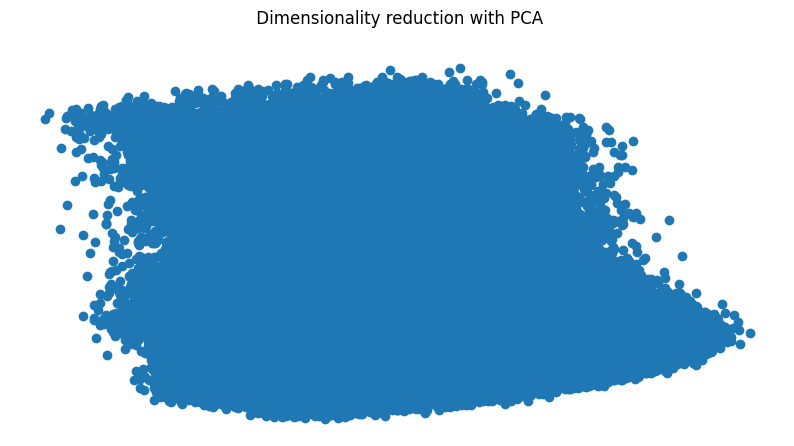

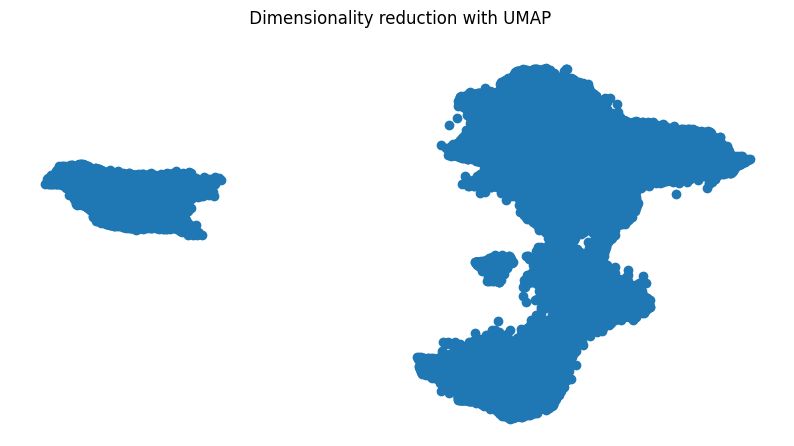

In [85]:
plot(pca_components,"PCA")
plot(umap_results,"UMAP")

 From above dimensionality reduction it clearly the UMAP is seperating spam and non spams better than the PCA. So will be selecting UMAP components to cluster the data.

In [87]:
components=umap_results

#### Apply clustering K-means and Gaussian mixture 

#### K-means

In [88]:
from sklearn.cluster import KMeans
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=2, random_state=250)

# Fit model
kmeans_fit = kmeans_cluster.fit(components)
y_pred = kmeans_cluster.predict(components)

In [89]:
def plot_pred(components,y_pred):
 plt.figure(figsize=(1,0.5))
 colours = ['r','b','g']
 for i in range(components.shape[0]):
    plt.text(components[i, 0], components[i, 1], str(y_pred[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 40}
        )

 plt.xticks([])
 plt.yticks([])
 plt.axis('off')
 plt.show()

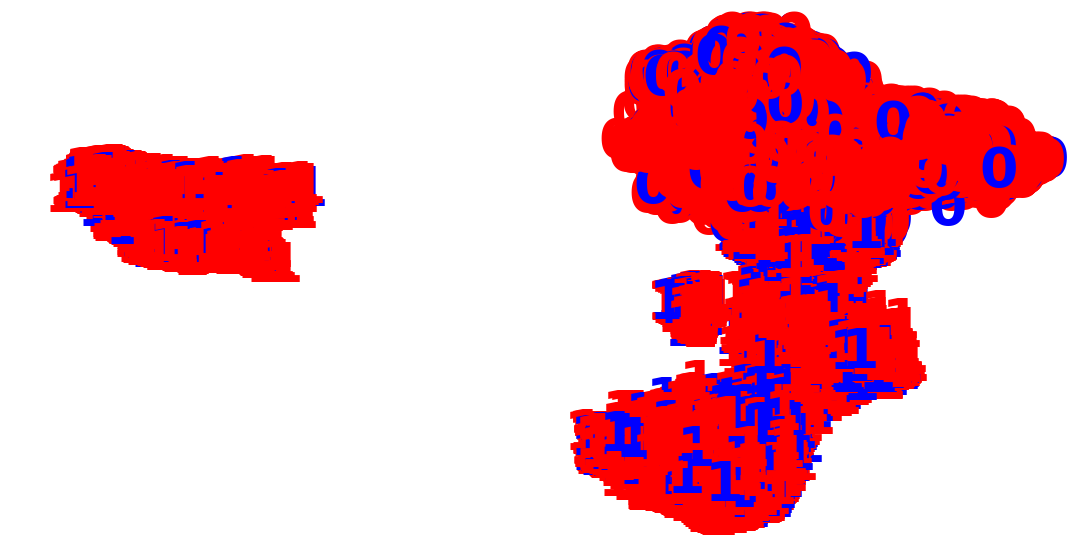

In [90]:
components.shape
plot_pred(components,y_pred)

In [91]:
pd.crosstab(y,y_pred)

col_0,0,1
Target,,
0,260653,108647
1,36540,23246


In [99]:
model_stats = []
from sklearn import  metrics
#print('silhouette_score:',metrics.silhouette_score(X_std, y_pred, metric='euclidean'))
print('random index:' , metrics.rand_score(y,y_pred))
print('adjusted random index:' ,metrics.adjusted_rand_score(y,y_pred))
#model_stats.append([metrics.silhouette_score(X_std, y_pred, metric='euclidean'),
#                metrics.rand_score(y,y_pred),
#                metrics.adjusted_rand_score(y,y_pred)]
#              )

random index: 0.5522517341900521
adjusted random index: 0.029568025161276


#### Gaussian mixture

In [103]:
from sklearn.mixture import GaussianMixture

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123)
# Fit model
clusters = gmm_cluster.fit_predict(components)

In [ ]:
plot_pred(components,clusters)

In [ ]:
print('silhouette_score:',metrics.silhouette_score(X, clusters, metric='euclidean'))
print('random index:' , metrics.rand_score(y,clusters))
print('adjusted random index:' ,metrics.adjusted_rand_score(y,clusters))
#model_stats.append([metrics.silhouette_score(X_std, clusters, metric='euclidean'),
#                metrics.rand_score(y,clusters),
#                metrics.adjusted_rand_score(y,clusters)]
#              )

In [ ]:
pd.crosstab(y,clusters)

### Selecting Clustering model based on performance

In [ ]:
# Create the plot
fig, ax1 = plt.subplots()

# Plot the first y-axis
ax1.plot( ['K-MEANS','GaussianMixture'],[model_stats[0][0],model_stats[1][0]], 'b-', label='silhouette_score / Adjusted Random index')
ax1.set_xlabel('MODEL')
ax1.set_ylabel('silhouette_score', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot( ['K-MEANS','GaussianMixture'],[model_stats[0][1],model_stats[1][1]], 'r-', label='Random index')
ax2.set_ylabel('Random index', color='r')
ax2.tick_params('y', colors='r')
ax1.plot( ['K-MEANS','GaussianMixture'],[model_stats[0][2],model_stats[1][2]], 'g-', label='Adjusted Random index')

fig.legend()
plt.show()

In [ ]:
 << write summary>> 

## Apply complex Deep learning(ANN) to determine the diabetic label

In [ ]:
# define model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
def build_model(activation_function,layers):
  model = Sequential()
  # The first dense layer
  model.add(Dense(2**(layers+4), input_shape=(784,), activation=activation_function))
  for layer in range(layers-1,1,-1):
    # The second dense layer
    model.add(Dense(2**(layer+4), activation=activation_function))
  # The last layer is the output layer
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model
def train_me(model,loss_function,batch_size):
  model.compile(optimizer='sgd', loss=loss_function,
              metrics=['accuracy'])
  # Setting `verbose=1` prints out some results after each epoch
  print("Learning rate before first fit:", model.optimizer.learning_rate.numpy())
  model.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=1)
def print_scores(model):
  score = model.evaluate(X_test, Y_test, verbose=0)
  print('Test score:', score[0])
  print('Test accuracy:', score[1])

In [ ]:
#* Number of layers  3, 5 ,7 run and see model performance
for layers in (3,5,7):
 model = build_model(activation_function='relu',layers=layers)    
 train_me(model,losses.categorical_crossentropy,batch_size)
 print_scores(model)

In [ ]:
#* Activation functions of the layers
for activation_function in ('tanh','sigmoid','relu'):
    print("model running with "+activation_function)
    model = build_model(activation_function,layers=3)
    train_me(model,losses.categorical_crossentropy,batch_size)
    print_scores(model)

In [ ]:
def build_model_nn(activation_function,layers,nn):
  model = Sequential()
  # The first dense layer
  model.add(Dense(nn[0], input_shape=(784,), activation=activation_function))
  # The second dense layer
  model.add(Dense(nn[1], activation=activation_function))
  # The last layer is the output layer
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

In [ ]:
#* Number of neurons in the layers
for nn in ((64,32),(128,64),(256,128)):
    model = build_model_nn(activation_function='tanh',layers=3,nn=nn)
    train_me(model,losses.categorical_crossentropy,batch_size)
    print_scores(model)

In [ ]:
#* Different batch sizes during training
for batch_size in (16,128,1024):
    model = build_model(activation_function='tanh',layers=3)
    train_me(model,losses.categorical_crossentropy,batch_size)
    print_scores(model)